In [45]:
#initial import
%matplotlib inline

import math
import pandas

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

import scipy
from scipy import optimize
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

#matplotlib.rcParams['text.usetex'] = True

strains = {}
loaded_files = []

In [46]:
# define functions

## dataset building functions


### get strain name 
def get_name(name): 
    s_name = name.split("_")[0]
    return s_name

### get list of dils
def get_dils(ndil, nrep, topdil, dilf):
    dil = []
    for d in xrange(ndil):
        for reps in xrange(nrep):
            dil.append(float(topdil))
        topdil = float(topdil)/dilf
        
    return np.array(dil)

### Get raw data and make lists 
def get_raw_data(name, ndil, nrep):
    ## get concentration columns

    sheet = pandas.read_excel(name)
    conc_columns = []
    for column in sheet:
        conc_columns.append(column)
    conc_columns = conc_columns[2:ndil+2]
    #print conc_columns

    ## first, get column data; then, per column, get test data and controls
    test_OD = []
    drug_OD = []
    pos_OD = []
    neg_OD = []
    for c_number in xrange(len(conc_columns)):
        #print c_number
        data = list(sheet[conc_columns[c_number]][2:8])
        #print data
        test_OD.append(data[:nrep])
        #print test_OD
        drug_OD.append(data[nrep])
        #print drug_OD
        if c_number < 3:
            pos_OD.append(data[nrep+2])
        if c_number>=3 and c_number < 6:
            neg_OD.append(data[nrep+2])
        
    return test_OD, drug_OD, pos_OD, neg_OD


## normalize test OD data to controls and calculate survival

def get_survival(test_OD, drug_OD, pos_OD, neg_OD):

    p_neg_control = np.mean(neg_OD)
    neg_OD = [OD - p_neg_control for OD in neg_OD]

    pos_OD = [OD-p_neg_control for OD in pos_OD]
    p_pos_control = np.mean(pos_OD)

    # calculate normalized survival
    neg_survival = np.array([(OD/p_pos_control)*100 for OD in neg_OD])
    pos_survival = np.array([(OD/p_pos_control)*100 for OD in pos_OD])

    # normalize to drug medium control and then to pos control
    drug_survival = []
    stdev_survival = []
    for concentration in xrange(len(test_OD)):
        ODs = test_OD[concentration]
        ODs = [OD - drug_OD[concentration] for OD in ODs]
        survival = [(OD/p_pos_control)*100 for OD in ODs]
        drug_survival.append(survival)
        stdev_survival.append(np.std(survival))

    drug_survival = np.array(drug_survival).flatten()

    return neg_survival, pos_survival, drug_survival, p_neg_control, p_pos_control, stdev_survival

def add_strain_data(strains, dil, drug_survival, neg_survival, pos_survival, stdev_survival):
    if s_name in strains.keys():
        print "strain data already existent - appending survival data to previous {0} info".format(s_name)
        pre = strains[s_name] # something like [dil, drug_survival, neg_survival, pos_survival]
        #print pre
        pre[0] = np.append(pre[0], dil)
        pre[1] = np.append(pre[1], drug_survival)
        pre[2] = np.append(pre[2], neg_survival)
        pre[3] = np.append(pre[3], pos_survival)
        pre[4] = np.append(pre[4], stdev_survival)

    elif s_name not in strains.keys():
        print "no previous strain data - adding new dilutions and %survival data for {0}".format(s_name)
        strains[s_name]=[dil, drug_survival, neg_survival, pos_survival, stdev_survival]

    return strains, s_name

def sigmoid(p,x):
    x0,y0,c,k=p
    y = c / (1 + np.exp(-k*(x-x0))) + y0
    return y

def residuals(p,x,y):
    return y - sigmoid(p,x)

#def resize(arr,lower=0.0,upper=1):#y.max()):
def resize(arr,upper, lower):#y.max()):
#def resize(arr,lower=0.0,upper=1):#y.max()):
    arr=arr.copy()
    if lower>upper: lower,upper=upper,lower
    arr -= lower
    arr *= (upper-lower)/upper
    arr += lower
    return arr

def plot_hist(strains):
    strain = raw_input("Select strain [data available for {0}] ".format(strains.keys()))
    #strain = "m2904"

    dil, drug_survival, neg_survival, pos_survival, stdev_survival = strains[strain][0], strains[strain][1], strains[strain][2], strains[strain][3], strains[strain][4]  
    av_survival = []
    stdev_all_srv = []

    #calculate average survival per concentration
    
    dil, drug_survival = (list(t) for t in zip(*sorted(zip(dil, drug_survival))))

    #print dil, drug_survival

    reps = dil.count(dil[0])
        
    c = 0
    av = []
    for i in drug_survival:
        av.append(i)
        c+=1
        if c == reps:
            #print av
            mean = np.mean(av)
            dev = np.std(av)
            av_survival.append(mean)
            stdev_all_srv.append(dev)
            av = []
            c = 0
    
    #append mean values of pos and neg controls to drug survival data
    mp = np.mean(pos_survival)
    mn = np.mean(neg_survival)    
    av_survival.append(mp)
    av_survival.append(mn)
    y = av_survival
    #print y
    
    #append stdev values of pos and neg controls to drug survival data
    stp = np.std(pos_survival)
    stn = np.std(neg_survival)
    stdev_all_srv = np.array(stdev_all_srv)
    stdev_all_srv= np.append(stdev_all_srv, np.array(stp))
    stdev_all_srv= np.append(stdev_all_srv, np.array(stn))    
    stdev_all_srv= stdev_all_srv.flatten()
    
    t = set()
    x = [i for i in dil if i not in t and t.add(i) is None]
    x += ["C+","C-"]
    
    #print len(x), len(y), len(stdev_all_srv)

    #print stdev_all_srv
    
    # now the plotting part
    ind = np.arange(len(x))  # the x locations for the groups
    width = 0.75  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width/2, y, width, yerr=stdev_all_srv,
                label='SbIII concentration')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% Survival')
    ax.set_title('{0} %survival given SbIII concentrations'.format(s_name))
    ax.set_xticks(ind)
    ax.set_xticklabels(x)
    ax.legend()

    fig.tight_layout()

    plt.show()
    
def plot_sigmoid(strains, plt_scale):
    
    strain = raw_input("Select strain [data available for {0}] ".format(strains.keys()))
    #strain = "m2904"
    dil, drug_survival, neg_survival, pos_survival, stdev_survival = strains[strain][0], strains[strain][1], strains[strain][2], strains[strain][3], strains[strain][4]  
    savefig = "yes" # raw_input("Save fig also? [yes/no] ")
    if plt_scale == "log":
        x = np.array([math.log(i) for i in dil])
        xp = np.linspace(-6, 4, 1500)
        plt.xlabel('log([SbIII])')


    elif plt_scale == "decimal": 
        x = dil
        xp = np.linspace(0, 50, 1500)
        plt.xlabel('[SbIII] (ug/mL)')


    y = np.array(drug_survival)
    #print np.shape(x), np.shape(y)

    #print np.argwhere(np.isnan(corr))
    #y=resize(y,maxi, mini)

    #print(x)
    #print(y)
    p_guess=(np.median(x),np.median(y),0,1.0)
    p, cov, infodict, mesg, ier = scipy.optimize.leastsq(
        residuals,p_guess,args=(x,y),full_output=1)  

    x0,y0,c,k=p
    print('''\
    x0 = {x0}
    y0 = {y0}
    c = {c}
    k = {k}
    '''.format(x0=x0,y0=y0,c=c,k=k))

    pxp=sigmoid(p,xp)

    #print x.shape, y.shape

    # Plot the results
    plt.plot(x, y, '.', label="supervivencia")
    plt.plot(xp, pxp, '-')#, label='y = {c} / (1 + e^(-{k}*(x-{x0}))) + {y0}'.format(x0=np.around(x0, decimals=2), \
                           #                                                        y0=np.around(y0, decimals=2), \
                            #                                                       c=np.around(c, decimals=2), \
                             #                                                      k=np.around(k, decimals=2)))
    plt.ylabel('porcentaje de supervivencia',rotation='vertical') 
    legend = plt.legend(loc='lower right', shadow=True, fontsize='small')
    plt.grid(True)

    plt.show()
    
    if savefig == "yes":

        plt.plot(x, y, '.', label="supervivencia")
        plt.plot(xp, pxp, '-')#, label='y = {c} / (1 + e^(-{k}*(x-{x0}))) + {y0}'.format(x0=np.around(x0, decimals=2), \
                       #                                                        y0=np.around(y0, decimals=2), \
                        #                                                       c=np.around(c, decimals=2), \
                         #                                                      k=np.around(k, decimals=2)))
        plt.ylabel('porcentaje de supervivencia',rotation='vertical') 
        legend = plt.legend(loc='lower right', shadow=True, fontsize='small')
        plt.grid(True)

        plt.savefig('{0}_SbIII_{1}.pdf'.format(strain, plt_scale), bbox_inches='tight')
        plt.gcf().clear()
    return x0,y0,c,k

def ld50(strain, x0, y0, c, k):
    
    print 70*"="
    print 'best fit equation is: y = {c} / (1 + e^(-{k}*(x-{x0}))) + {y0}'.format(x0=np.around(x0, decimals=2), \
                                                                                   y0=np.around(y0, decimals=2), \
                                                                                   c=np.around(c, decimals=2), \
                                                                                   k=np.around(k, decimals=2))

    x0=x0
    y0=y0
    c=c
    k=k

    dil, drug_survival, neg_survival, pos_survival, stdev_survival = strains[strain][0], strains[strain][1], strains[strain][2], strains[strain][3], strains[strain][4]  

    x = np.array([math.log(i) for i in dil])
    y = np.array(drug_survival)

    #print np.shape(x), np.shape(y)
    #print x, y

    func = lambda x : 50 - (c / (1 + np.exp(-k*(x-x0)))) - y0

    x_guess = 0.5
    sol = fsolve(func, x_guess)
    val = func(sol)
    LD50 = 10**(sol)

    return sol, LD50, val

In [47]:
# Get information about excel data file -- see template 
# for layout pointers

print 70*"="
name = raw_input("Enter data file name: ")
#name = "m2904_E1.xls" 


if name in loaded_files:
    print ("File data has already been loaded.")
    exit()
else:
    loaded_files.append(name)
    pass
ndil = input("Enter number of concentrations tested: ") # 8
topdil = input("Enter starting concentration: ") # 50
dilf = input("Enter dilution factor (i.e. 4 -> 1/4 dilution): ") # 4
nrep = input("Enter number of replicas per concentration: ") # 3
print 70*"="
print "\n"

print 70*"="
# initialize strain dict

# get strain name 
s_name = get_name(name)
print "strain name: {0}".format(s_name)

# generate list of dilutions
dil = get_dils(ndil, nrep, topdil, dilf)

# Load data and store in lists; these will ultimately 
# be stored into a dict of strains, once normalized to control
# and transformed to %survival
# {s_name1: [dil, survival]; s_name2: [dil, survival]}

test_OD, drug_OD, pos_OD, neg_OD = get_raw_data(name, ndil, nrep)

neg_survival, pos_survival, drug_survival, p_neg_control, p_pos_control, stdev_survival = get_survival(test_OD, drug_OD, pos_OD, neg_OD)
#print neg_survival, pos_survival, drug_survival

## add the survival percentages to the strain dictionary 

#strains = {"m2904":[np.array([1]),np.array([2]),np.array([3]),np.array([4])]}

strains, strain = add_strain_data(strains, dil, drug_survival, neg_survival, pos_survival, stdev_survival)
#print strains
print 70*"="

Enter data file name: m2904_E1.xls
Enter number of concentrations tested: 8
Enter starting concentration: 50
Enter dilution factor (i.e. 4 -> 1/4 dilution): 4
Enter number of replicas per concentration: 3


strain name: m2904
no previous strain data - adding new dilutions and %survival data for m2904


Select strain [data available for ['m2904']] m2904


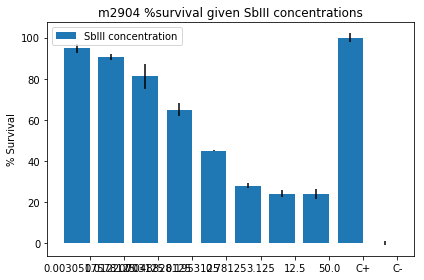

In [48]:
## Plot a histogram for percent survival

plt_hist = "yes" # raw_input("Plot histogram for survival data? [yes/no] ")

if plt_hist == "yes":
    plot_hist(strains)


Select strain [data available for ['m2904']] m2904
    x0 = -1.24998111223
    y0 = 95.4807634815
    c = -73.8231756227
    k = 0.853457598434
    


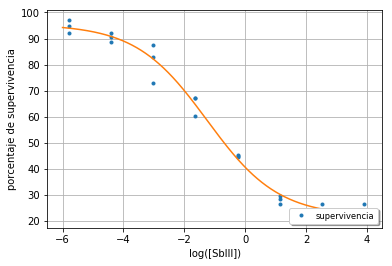

<Figure size 432x288 with 0 Axes>

In [49]:
## calculate sigmoid regression and plot it 
plt_sigmoid = "yes" # raw_input("Calculate + plot sigmoid regression for survival data? [yes/no] ")
plt_scale = "log" # raw_input("Scale for sigmoid plot [decimal/log]: ")

if plt_sigmoid == "yes":
    x0,y0,c,k= plot_sigmoid(strains, plt_scale)


In [50]:
# Calculate the LD50
strain = raw_input("Select strain [data available for {0}] ".format(strains.keys()))    
sol,LD50, val = ld50(strain, x0,y0,c,k)

print "The solution is x = %f (log scale [SbIII])" % sol
print "at which the value of the expression is %f" % val

print "\nLD50 of SbIII for the strain is %f ug/mL" %LD50

print 70*"="

Select strain [data available for ['m2904']] m2904
best fit equation is: y = -73.82 / (1 + e^(-0.85*(x--1.25))) + 95.48
The solution is x = -0.695847 (log scale [SbIII])
at which the value of the expression is 0.000000

LD50 of SbIII for the strain is 0.201443 ug/mL
